# Long short-term memory (LSTM) for Battery Management System (BMS) State of Charge (SOC) and State of Health (SOH) Estimation

<img src="../../doc/img/LSTMNetwork.jpg" height="530"
     alt="Machine Learning Network"
     style="fit: left; margin-right: 10px;"  />

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

# adding new libraries
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.layers import Activation 
from tensorflow.keras import layers, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from tensorflow.keras.optimizers import Adam


# Import Data

In [2]:
# Import Data
df = pd.read_csv('../../res/model_data/batemo_model_data.csv')
df.describe()


,V,I,SOC,T_surf,SOH
count,1.640946e+06,1.640946e+06,1.640946e+06,1.640946e+06,1.640946e+06
mean,3.471013e+00,3.610140e+00,4.188879e+01,5.180549e+01,8.566437e+01
std,8.445745e-01,2.830966e+01,4.022232e+01,2.451698e+01,9.026790e+00
min,-9.394656e-01,-5.500295e+01,-5.753759e+00,2.499965e+01,7.000000e+01
25%,3.144859e+00,-1.900000e+01,1.230206e+00,2.583835e+01,7.800000e+01
50%,3.693897e+00,5.000000e+00,3.474387e+01,4.826449e+01,8.600000e+01
75%,4.064538e+00,2.600000e+01,8.456010e+01,7.304868e+01,9.400000e+01
max,4.723157e+00,5.500289e+01,1.070423e+02,1.015903e+02,1.000000e+02


# Train Test Split

In [3]:
# Define training variables
# TODO: need to consider if keeping current (I) is a valuable input feature or not (test if the model performs better w/o it)
X = df[['V', 'I']].values

# TODO: add calculating SOP
# LSTM output with 2 nodes (SOH and SOC) 
Y = df[['SOC', 'SOH']].values

# Normalize input data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)  # use normalized features to prevent over-fitting (X_scaled)

# Define function to create sequences
# NOTE: The creation of input-output pairs allows the model to learn from historical context. The input sequences serve as a history of past observations, while the corresponding output (target) provides the next observation in the sequence.This historical context is crucial for making accurate predictions, especially in time-series forecasting or sequence prediction tasks where the future state depends on past states
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Features (voltage, current, temperature, state of charge) are turned into a list of historical values 
        y.append(data[i + seq_length])     # Target variables (SOH and SOC) are turned into a list of historical values 
    return np.array(X), np.array(y)

# Choose sequence length
seq_length = 1 # sequence length set to 1 to take immediate values from sensor reading during testing 
# NOTE:  Even with seq_length of 1, organizing the data into sequences might provide the model with some historical context. Although the immediate historical context is limited, the model can still potentially learn from patterns and trends in the data over time
# TODO: may need to increase the sequence length if the model performs poorly on testing (sensor) data 

# Create sequences for training and testing data
X_train_seq, y_train_seq = create_sequences(x_train, seq_length)
X_test_seq, y_test_seq = create_sequences(x_test, seq_length)

print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_test_seq.shape)
print(y_test_seq.shape)

(1312755, 1, 2)
(1312755, 2)
(328189, 1, 2)
(328189, 2)


# Fit Model


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10600     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 10702 (41.80 KB)
Trainable params: 10702 (41.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
41024/41024 [==============================] - 117s 3ms/step - loss: 0.0449 - val_loss: 0.0444
Epoch 2/10
41024/41024 [==============================] - 97s 2ms/step - loss: 0.0443 - val_loss: 0.0444
Epoch 3/10
41024/41024 [==============================] - 101s 2ms/step - loss: 0.0443 - val_loss: 0.0443
Epoch 4/10
41024/41024 [==============================] - 99s 2ms/step - loss: 0.0443 - val_loss: 

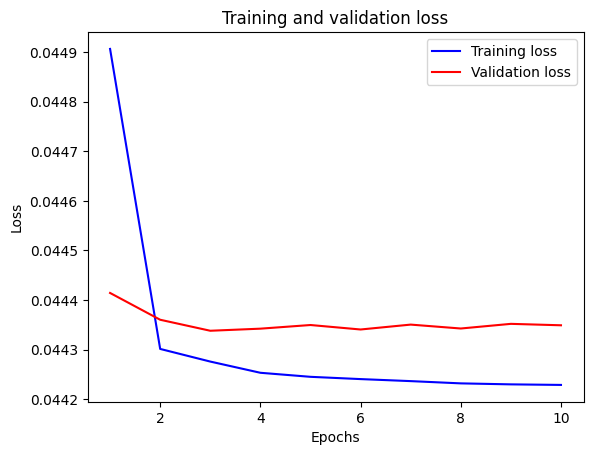

In [4]:
# Define model for predicting SOH and SOC 
model = Sequential()

# Defining a model for predicting SOH and SOC
model.add(LSTM(50, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

model.add(Dense(units=2))  # Output layer for two continuous values: SOC and SOH

# Compile model with Adam optimizer and default learning rate
model.compile(optimizer='adam', loss='mean_squared_error')

# NOTE: .summary() is a method used in Keras, a high-level deep learning library, to display a summary of the neural network model's architecture. it will print out the layer name, layer type, output shape, number of parameters and trainable/non-trainable params
model.summary()

# Train the model and store the history
history = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq))

# Extract loss values from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting the loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO: THINGS TO CONSIDER FOR FINE-TUNING HYPERPARAMETERS
# TODO: 1) consider altering the depth of the network. currently we have 1 hidden layer 
# TODO: 2) consider altering the width of the network. currently there are 50 nodes 
# TODO: 3) consider altering the activation function. right now it is set to be relu 
# TODO: 4) consider altering the optimizer. right now it is set to Adam
# TODO: 5) consider altering the number of epochs 

# Test Model / Predict

In [6]:
# Preprocess and create sequences for new data
# TODO: once loaded onto the microcontroller, new_data will be the sensor reading 
# new_data_scaled = scaler.transform(new_data)
# new_X_seq, _ = create_sequences(new_data_scaled, seq_length)

# Reshape input data for LSTM
x_test_reshaped = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

# Evaluate the model
loss = model.evaluate(x_test_reshaped, y_test_seq)
print("Test Loss:", loss)

# Make predictions
predictions = model.predict(x_test_reshaped)  # todo: consider sending a sinusoid, square wave, etc as input to test the model


10256/10256 [==============================] - 15s 1ms/step - loss: 0.0443
Test Loss: 0.04434894770383835
10256/10256 [==============================] - 14s 1ms/step


# Save Model and Export (Optimize for Size)

In [9]:
# # Model Export
# save Keras model
model.save("model_file_name" +'.h5')

# Convert Keras model to a TensorFlow Lite model 
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Disable experimental lowering of tensor list ops
converter._experimental_lower_tensor_list_ops = False

# Specify to use select TensorFlow ops
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Convert the model
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("model_file_name.tflite", 'wb') as f:
    f.write(tflite_model)

# TODO: see if we can minimize the size of the tflite file in this block 

C:\Users\Caiti\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: C:\Users\Caiti\AppData\Local\Temp\tmp894a0j8b\assets


INFO:tensorflow:Assets written to: C:\Users\Caiti\AppData\Local\Temp\tmp894a0j8b\assets
